In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, 
    confusion_matrix, classification_report,
    f1_score, average_precision_score, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [4]:
testing_path = "../isic_2019/ISIC_2019_Test_Input/ISIC_2019_Test_Input"

testing_labels_path = "../isic_2019/ISIC_2019_Test_Input/ISIC_2019_Test_GroundTruth.csv"

testing_labels = pd.read_csv(testing_labels_path)
print("Found testing labels")

def load_data(path):
    data = []
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            # print(filename)
            data.append(filename)
    return data


testing_data = load_data(testing_path)
print("Testing data: ", len(testing_data))

print("Testing labels: ", len(testing_labels))

Found testing labels
Testing data:  8238
Testing labels:  8238


In [5]:
df = testing_labels
print("Training labels preview:")
print(df.head())


# Peek of MEL column and NON-MEL values
melanoma_count = df[df["MEL"] == 1].shape[0]
non_melanoma_count = df[df["MEL"] == 0].shape[0]

# Printing the counts
print(f"Melanoma images: {melanoma_count}")
print(f"Non-Melanoma images: {non_melanoma_count}")

# Get overall class distribution
print(df["MEL"].value_counts(normalize=True) * 100)  # Shows % distribution

Training labels preview:
          image  MEL
0  ISIC_0034321  0.0
1  ISIC_0034322  0.0
2  ISIC_0034323  0.0
3  ISIC_0034324  0.0
4  ISIC_0034325  0.0
Melanoma images: 1327
Non-Melanoma images: 6911
MEL
0.0    83.891721
1.0    16.108279
Name: proportion, dtype: float64


In [6]:
'''FILTERING IMAGES'''
# Hair removal
def remove_hair(img):
    #Black hat filter
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(7,17))
    blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)
    #Gaussian filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
    #Binary thresholding (MASK)
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
    #Replace pixels of the mask
    dst = cv2.inpaint(img,mask,7,cv2.INPAINT_TELEA)
    # plt.imshow(dst)
    # plt.show
    return dst
    
# Gray scale
def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
# Noise reduction
def reduce_noise(image):
    bilateral = cv2.bilateralFilter(image, 9, 75, 75)
    median = cv2.medianBlur(bilateral, 5)
    return median
    
# Contrast enhancement
def enhance_contrast(image):
    enhanced_img = (cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))).apply(image)
    return enhanced_img

# Resizing
def resize_img(img, size=(224, 224)):
    resized_img = cv2.resize(img, size)
    return resized_img

# Other filters (need to debug)

# Edge detection
def segment_lesion(image):
        
    #https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html 
    # look at Otsu binarization; very nice
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

def enhance_borders(image):

    # https://docs.opencv.org/4.x/d2/d2c/tutorial_sobel_derivatives.html
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient = np.sqrt(sobelx**2 + sobely**2)
    
    gradient = np.uint8(gradient * 255 / gradient.max())
    return gradient


In [35]:
'''PREPROCESSING IMAGES'''
import shutil
def preprocessing(image):
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = convert_to_grayscale(image)
    hair_remove = remove_hair(gray)
    noise_reduced = reduce_noise(hair_remove)
    
    contrast = enhance_contrast(noise_reduced)

    # Very wonky things happen depending on specific images when trying to get specific borders
    #mask = segment_lesion(image)   
    # borders = enhance_borders(noise_reduced)
    #final = cv2.bitwise_and(contrast, contrast, mask=mask)

    resized = cv2.resize(contrast, (224,224))
    return resized

def preprocess_all_images(image_list, output_dir):
    if not os.path.exists(output_dir):
        print("Creating output directory")
        os.makedirs(output_dir)
    elif os.path.exists(output_dir):
        print("Output directory already exists, deleting")
        shutil.rmtree(output_dir)
        os.makedirs(output_dir)
    
    i = 0
    for image_name in range(len(image_list)): # <------------------- Change for full dataset len(image_list)
        i += 1
        if i % 1000 == 0:
            print(f"Preprocessing image {i}/{len(image_list)}")
        image_name = image_list[image_name]
        image_path = os.path.join(testing_path, image_name)
        preprocessed_image = preprocessing(image_path)
        output_path = os.path.join(output_dir, image_name)
        cv2.imwrite(output_path, preprocessed_image)
        
    print("Total Preprocessed: ", i)


preprocess_all_images(testing_data, "../testing_preprocessed_images")

Output directory already exists, deleting
Preprocessing image 1000/8238
Preprocessing image 2000/8238
Preprocessing image 3000/8238
Preprocessing image 4000/8238
Preprocessing image 5000/8238
Preprocessing image 6000/8238
Preprocessing image 7000/8238
Preprocessing image 8000/8238
Total Preprocessed:  8238


In [7]:
'''UPDATING LABELS'''

def update_labels(labels_path):
    df = pd.read_csv(labels_path)
    df = df[['image', 'MEL']] # Drop other columns
    df.to_csv(labels_path, index=False)
    return df


df_test_labels_updated = update_labels(testing_labels_path)
print(df_test_labels_updated.head())
print(df_test_labels_updated.shape)

          image  MEL
0  ISIC_0034321  0.0
1  ISIC_0034322  0.0
2  ISIC_0034323  0.0
3  ISIC_0034324  0.0
4  ISIC_0034325  0.0
(8238, 2)


In [8]:
'''CONVERTING IMAGES TO ARRAYS FOR MODEL'''

def load_process_images(image_path):
    # image_path += ".jpg"
    img = load_img(image_path)
    img_array = img_to_array(img)

    img_array = img_array / 255.0
    return img_array


def get_all_data(all_images, labels_df, path):
    images = []
    all_labels = []

    
    labels_dict = dict(zip(labels_df['image'], labels_df['MEL']))

    for img in all_images:
        img_path = os.path.join(path, img).replace("\\", "/")
        img_pixels = load_process_images(img_path)
        
        
        img_name = img.replace('.jpg', '')
        label = float(labels_dict[img_name])  

        images.append(img_pixels)
        all_labels.append(label)
    
    return np.array(images), np.array(all_labels)

In [9]:
'''VISUALIZATIONS'''
def plot_roc_curve(y_true, y_prediction, name):
    fpr, tpr, _ = roc_curve(y_true, y_prediction)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc="lower right")


def plot_confusion_matrix(y_true, y_pred, name):
    print(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Model loaded
258/258 ━━━━━━━━━━━━━━━━━━━━ 45s 173ms/step


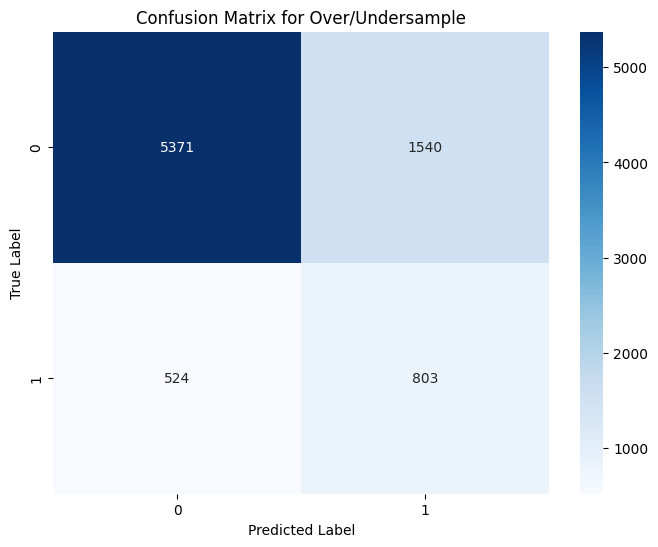

Results for Over/Undersample:
Accuracy:  0.7494537234306335
AUC Score: 0.767
F1 Score: 0.438
Average Precision: 0.427


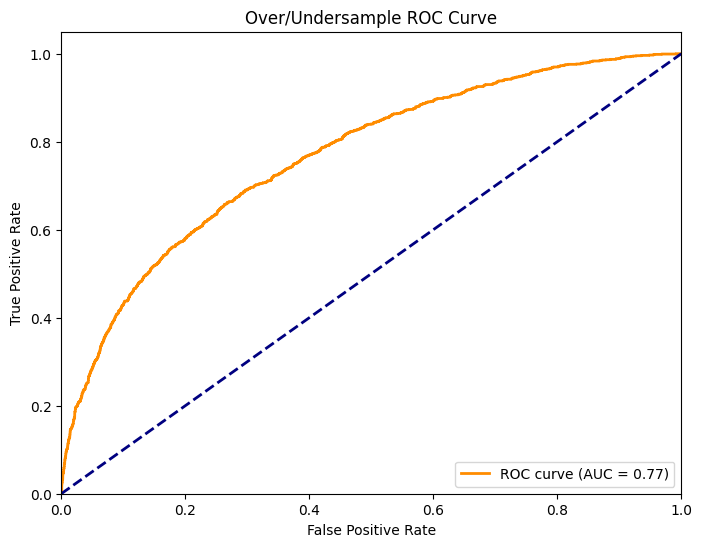

In [11]:
'''EVALUATING MODEL ON TESTING DATA'''

# model_path = "../melanoma_combo_model.keras"
# model_path = "../melanoma_undersample_model.keras"
model_path = "../melanoma_experimental_model.keras"
model = tf.keras.models.load_model(model_path)
print("Model loaded")

BATCH_SIZE = 32


def evaluate_model(model, X_test, y_test, name):
    
    y_predictions = model.predict(X_test, batch_size=BATCH_SIZE)
    y_pred = (y_predictions >= 0.5).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    
    print(f"Results for {name}:")
    auc_score = roc_auc_score(y_test, y_predictions)
    f1 = f1_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_predictions)
    
    print("Accuracy: ", model.evaluate(X_test, y_test, verbose=0)[1])
    print(f"AUC Score: {auc_score:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Average Precision: {avg_precision:.3f}")

    
    fpr, tpr, _ = roc_curve(y_test, y_predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


X_test, y_test = get_all_data(testing_data, df_test_labels_updated, "../testing_preprocessed_images")

# evaluate_model(model, X_test, y_test, "Undersample")
evaluate_model(model, X_test, y_test, "Over/Undersample")